In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision.models as models
import torchvision
import torchvision.ops as ops  # NMS 적용을 위해 추가

# Mask R-CNN 모델 정의 및 로드
class ObjectSegmenter:
    def __init__(self, threshold=0.001, iou_threshold=0.3, brightness_threshold=200):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Pre-trained Mask R-CNN 모델 로드
        self.model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='MaskRCNN_ResNet50_FPN_Weights.COCO_V1')
        self.model.to(self.device)
        self.model.eval()
        self.threshold = threshold
        self.iou_threshold = iou_threshold
        self.brightness_threshold = brightness_threshold  # 밝기 기준 추가
        self.transform = T.Compose([
            T.ToTensor()
        ])

    def segment_image(self, image_path):
        # 이미지 로드 및 전처리
        image = Image.open(image_path).convert("RGB")
        input_tensor = self.transform(image).unsqueeze(0).to(self.device)

        # 모델 추론
        with torch.no_grad():
            predictions = self.model(input_tensor)

        # 예측 결과에서 마스크와 클래스 추출
        boxes = predictions[0]['boxes']
        masks = predictions[0]['masks']
        labels = predictions[0]['labels']
        scores = predictions[0]['scores']

        # 특정 임계값 이상인 객체들만 선택
        keep = scores >= self.threshold
        boxes = boxes[keep]
        masks = masks[keep]
        labels = labels[keep]
        scores = scores[keep]

        # NMS (Non-Maximum Suppression)를 통해 중복된 객체 필터링
        keep_indices = ops.nms(boxes, scores, self.iou_threshold)
        boxes = boxes[keep_indices]
        masks = masks[keep_indices]
        labels = labels[keep_indices]
        scores = scores[keep_indices]

        # 최종 선택된 객체들의 마스크 및 레이블 저장
        selected_masks = []
        for i in range(len(scores)):
            mask = masks[i, 0].mul(255).byte().cpu().numpy()  # 마스크를 0-255로 스케일링
            selected_masks.append((mask, labels[i].item()))

        return selected_masks, np.array(image)

    def extract_and_visualize_objects(self, image_np, masks):
        # 객체 크기 기준으로 상위 3개 선택
        mask_sizes = [(i, np.sum(mask > 128)) for i, (mask, _) in enumerate(masks)]
        top_3_indices = sorted(mask_sizes, key=lambda x: x[1], reverse=True)[:3]

        # 배경 마스크 초기화 (모든 영역을 배경으로 시작)
        background_mask = np.ones(image_np.shape[:2], dtype=np.uint8) * 255

        # 각 객체를 이미지로 추출하고 시각화 (상위 3개만)
        for idx, (i, _) in enumerate(top_3_indices):
            mask, label = masks[i]
            # 객체 마스크에 따른 추출
            object_mask = mask > 128
            extracted_object = np.zeros_like(image_np)
            extracted_object[object_mask] = image_np[object_mask]

            # 배경에서 객체 부분을 제거
            background_mask[object_mask] = 0

            # 추출된 객체 이미지 시각화
            plt.figure(figsize=(5, 5))
            plt.imshow(extracted_object)
            plt.title(f"Extracted Object {idx + 1} (Label: {label})")
            plt.axis('off')
            plt.show()

            # 색상 스키마 추출
            object_colors = image_np[object_mask]
            if len(object_colors) > 0:
                kmeans_object = KMeans(n_clusters=min(len(object_colors), 5)).fit(object_colors)
                object_palette = kmeans_object.cluster_centers_
            else:
                object_palette = np.array([])

            # 색상 스키마 시각화
            self.plot_color_palette(object_palette, f"Color Scheme of Object {idx + 1}")

        # 배경 이미지 추출 및 시각화
        background_mask_bool = background_mask == 255
        background_image = np.zeros_like(image_np)
        background_image[background_mask_bool] = image_np[background_mask_bool]

        # 배경 이미지 시각화
        plt.figure(figsize=(5, 5))
        plt.imshow(background_image)
        plt.title("Background Image")
        plt.axis('off')
        plt.show()

        # 밝은 영역 추가 탐지 (조명과 같은 작은 객체가 놓치는 경우 보완)
        bright_mask = cv2.cvtColor(background_image, cv2.COLOR_RGB2GRAY) > self.brightness_threshold
        bright_extracted_object = np.zeros_like(image_np)
        bright_extracted_object[bright_mask] = image_np[bright_mask]

        # 밝은 영역 시각화
        if np.any(bright_mask):
            plt.figure(figsize=(5, 5))
            plt.imshow(bright_extracted_object)
            plt.title("Bright Object Detected from Background")
            plt.axis('off')
            plt.show()

            # 색상 스키마 추출
            bright_colors = image_np[bright_mask]
            if len(bright_colors) > 0:
                kmeans_bright = KMeans(n_clusters=min(len(bright_colors), 5)).fit(bright_colors)
                bright_palette = kmeans_bright.cluster_centers_
            else:
                bright_palette = np.array([])

            # 색상 스키마 시각화
            self.plot_color_palette(bright_palette, "Color Scheme of Bright Object")

        # 배경 색상 스키마 추출
        background_colors = image_np[background_mask_bool]
        if len(background_colors) > 0:
            kmeans_background = KMeans(n_clusters=min(len(background_colors), 5)).fit(background_colors)
            background_palette = kmeans_background.cluster_centers_
        else:
            background_palette = np.array([])

        # 배경 색상 스키마 시각화
        self.plot_color_palette(background_palette, "Color Scheme of Background")

    @staticmethod
    def plot_color_palette(colors, title):
        if len(colors) == 0:
            print(f"No colors to display for {title}")
            return
        fig, ax = plt.subplots(1, 1, figsize=(10, 2), subplot_kw=dict(xticks=[], yticks=[], frame_on=False))
        palette = np.zeros((50, len(colors) * 50, 3), dtype=np.uint8)
        for i, color in enumerate(colors):
            palette[:, i * 50:(i + 1) * 50] = color[:3]
        ax.imshow(palette)
        plt.title(title)
        plt.show()

# ObjectSegmenter 인스턴스 생성 및 객체 분할 수행
segmenter = ObjectSegmenter(threshold=0.001, iou_threshold=0.3, brightness_threshold=200)  # 임계값을 낮추고 밝은 영역 탐지 추가
masks, image_np = segmenter.segment_image("./test_image/img1.png")

# 각 객체별 이미지와 색상 스키마, 배경 이미지 및 밝은 객체와 배경 색상 스키마 시각화
segmenter.extract_and_visualize_objects(image_np, masks)


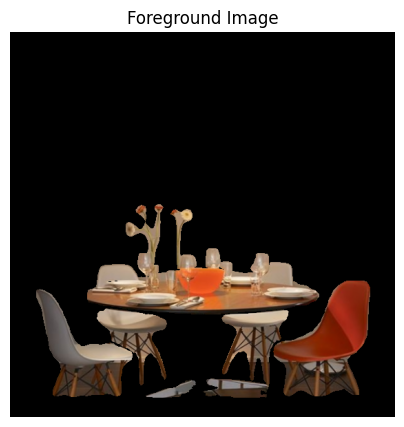

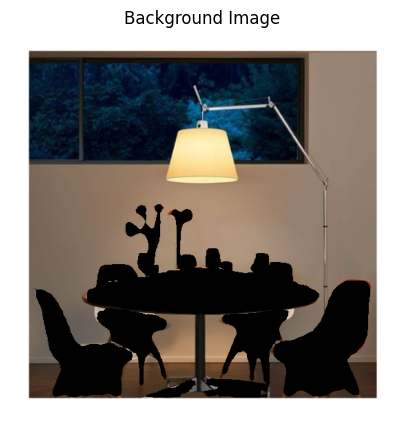

Color Scheme of Foreground - Color 1: RGB(116, 98, 84)
Color Scheme of Foreground - Color 2: RGB(190, 167, 143)
Color Scheme of Foreground - Color 3: RGB(185, 118, 75)
Color Scheme of Foreground - Color 4: RGB(66, 44, 29)
Color Scheme of Foreground - Color 5: RGB(138, 44, 18)


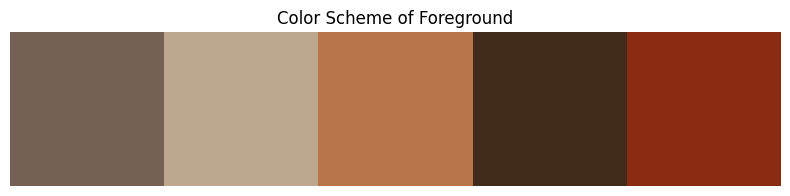

Color Scheme of Background - Color 1: RGB(13, 72, 105)
Color Scheme of Background - Color 2: RGB(254, 252, 246)
Color Scheme of Background - Color 3: RGB(148, 126, 107)
Color Scheme of Background - Color 4: RGB(83, 63, 47)
Color Scheme of Background - Color 5: RGB(8, 22, 38)


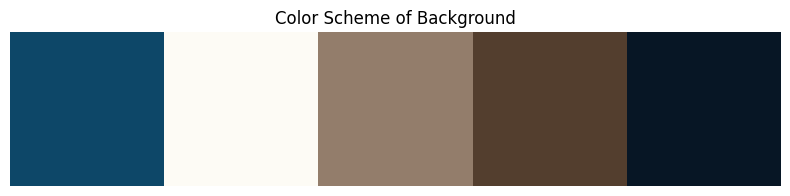

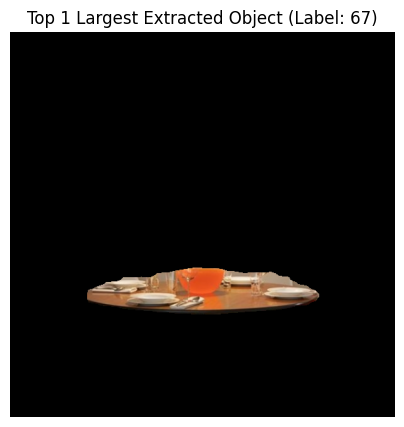

Color Scheme of Top 1 Largest Object - Color 1: RGB(184, 151, 120)
Color Scheme of Top 1 Largest Object - Color 2: RGB(60, 40, 25)
Color Scheme of Top 1 Largest Object - Color 3: RGB(164, 112, 73)
Color Scheme of Top 1 Largest Object - Color 4: RGB(230, 207, 181)
Color Scheme of Top 1 Largest Object - Color 5: RGB(225, 95, 39)


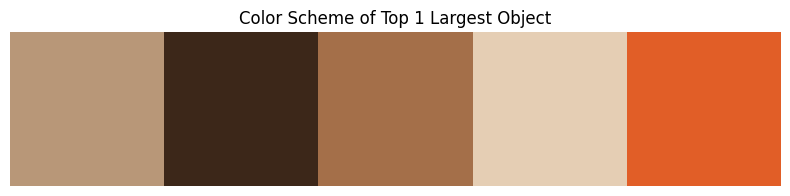

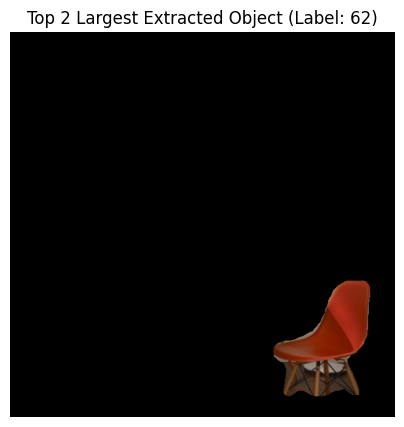

Color Scheme of Top 2 Largest Object - Color 1: RGB(63, 42, 28)
Color Scheme of Top 2 Largest Object - Color 2: RGB(160, 47, 26)
Color Scheme of Top 2 Largest Object - Color 3: RGB(139, 119, 106)
Color Scheme of Top 2 Largest Object - Color 4: RGB(120, 70, 46)
Color Scheme of Top 2 Largest Object - Color 5: RGB(128, 34, 7)


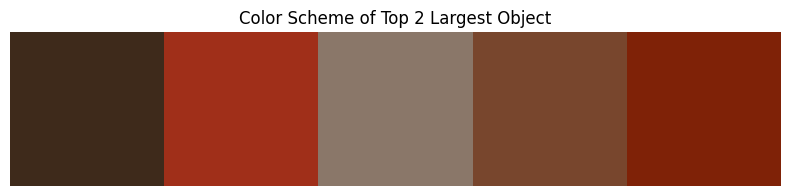

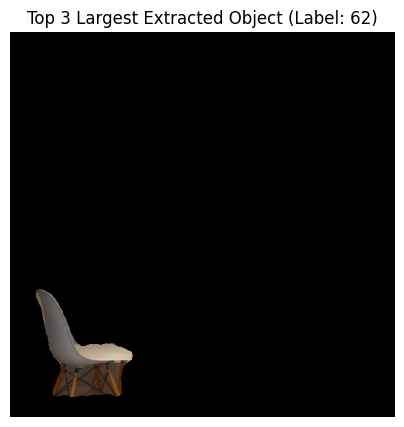

Color Scheme of Top 3 Largest Object - Color 1: RGB(93, 81, 75)
Color Scheme of Top 3 Largest Object - Color 2: RGB(188, 170, 147)
Color Scheme of Top 3 Largest Object - Color 3: RGB(115, 107, 103)
Color Scheme of Top 3 Largest Object - Color 4: RGB(59, 35, 18)
Color Scheme of Top 3 Largest Object - Color 5: RGB(76, 56, 42)


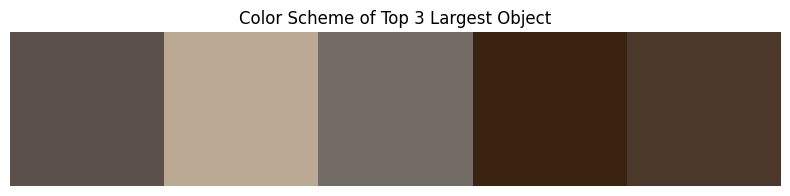

In [4]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision.models as models
import torchvision
import torchvision.ops as ops  # NMS 적용을 위해 추가

# Mask R-CNN 모델 정의 및 로드
class ObjectSegmenter:
    def __init__(self, threshold=0.001, iou_threshold=0.3, brightness_threshold=200):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Pre-trained Mask R-CNN 모델 로드
        self.model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='MaskRCNN_ResNet50_FPN_Weights.COCO_V1')
        self.model.to(self.device)
        self.model.eval()
        self.threshold = threshold
        self.iou_threshold = iou_threshold
        self.brightness_threshold = brightness_threshold  # 밝기 기준 추가
        self.transform = T.Compose([T.ToTensor()])

    def segment_image(self, image_path):
        # 이미지 로드 및 전처리
        image = Image.open(image_path).convert("RGB")
        input_tensor = self.transform(image).unsqueeze(0).to(self.device)

        # 모델 추론
        with torch.no_grad():
            predictions = self.model(input_tensor)

        # 예측 결과에서 마스크와 클래스 추출
        boxes = predictions[0]['boxes']
        masks = predictions[0]['masks']
        labels = predictions[0]['labels']
        scores = predictions[0]['scores']

        # 특정 임계값 이상인 객체들만 선택
        keep = scores >= self.threshold
        boxes = boxes[keep]
        masks = masks[keep]
        labels = labels[keep]
        scores = scores[keep]

        # NMS (Non-Maximum Suppression)를 통해 중복된 객체 필터링
        keep_indices = ops.nms(boxes, scores, self.iou_threshold)
        boxes = boxes[keep_indices]
        masks = masks[keep_indices]
        labels = labels[keep_indices]
        scores = scores[keep_indices]

        # 최종 선택된 객체들의 마스크 및 레이블 저장
        selected_masks = []
        for i in range(len(scores)):
            mask = masks[i, 0].mul(255).byte().cpu().numpy()  # 마스크를 0-255로 스케일링
            selected_masks.append((mask, labels[i].item()))

        return selected_masks, np.array(image)

    def extract_and_visualize_objects(self, image_np, masks):
        # 배경 마스크 초기화 (모든 영역을 배경으로 시작)
        background_mask = np.ones(image_np.shape[:2], dtype=np.uint8) * 255

        # 각 객체의 마스크를 배경에 반영 (배경 마스크 업데이트)
        for mask, _ in masks:
            background_mask[mask > 128] = 0

        # 전경 이미지 생성 (배경을 제외한 나머지를 전경으로 설정)
        foreground_mask = background_mask == 0
        foreground_image = np.zeros_like(image_np)
        foreground_image[foreground_mask] = image_np[foreground_mask]

        # 배경 이미지 생성
        background_image = np.zeros_like(image_np)
        background_mask_bool = background_mask == 255
        background_image[background_mask_bool] = image_np[background_mask_bool]

        # 전경 이미지 시각화
        plt.figure(figsize=(5, 5))
        plt.imshow(foreground_image)
        plt.title("Foreground Image")
        plt.axis('off')
        plt.show()

        # 배경 이미지 시각화
        plt.figure(figsize=(5, 5))
        plt.imshow(background_image)
        plt.title("Background Image")
        plt.axis('off')
        plt.show()

        # 밝은 영역 추가 탐지 (조명과 같은 작은 객체가 놓치는 경우 보완)
        bright_mask = cv2.cvtColor(background_image, cv2.COLOR_RGB2GRAY) > self.brightness_threshold
        bright_extracted_object = np.zeros_like(image_np)
        bright_extracted_object[bright_mask] = image_np[bright_mask]
        
        # 전경 색상 스키마 추출
        foreground_colors = image_np[foreground_mask]
        if len(foreground_colors) > 0:
            kmeans_foreground = KMeans(n_clusters=min(len(foreground_colors), 5)).fit(foreground_colors.reshape(-1, 3))
            foreground_palette = kmeans_foreground.cluster_centers_
        else:
            foreground_palette = np.array([])

        # 배경 색상 스키마 추출
        background_colors = image_np[background_mask_bool]
        if len(background_colors) > 0:
            kmeans_background = KMeans(n_clusters=min(len(background_colors), 5)).fit(background_colors.reshape(-1, 3))
            background_palette = kmeans_background.cluster_centers_
        else:
            background_palette = np.array([])

        # 전경 및 배경 색상 스키마 시각화 및 RGB 값 출력
        self.plot_color_palette_with_rgb(foreground_palette, "Color Scheme of Foreground")
        self.plot_color_palette_with_rgb(background_palette, "Color Scheme of Background")

        # 객체 크기 기준으로 상위 3개 선택
        mask_sizes = [(i, np.sum(mask > 128)) for i, (mask, _) in enumerate(masks)]
        top_3_indices = sorted(mask_sizes, key=lambda x: x[1], reverse=True)[:3]

        # 상위 3개 객체 시각화 및 색상 스키마 추출
        for idx, (i, _) in enumerate(top_3_indices):
            mask, label = masks[i]
            # 객체 마스크에 따른 추출
            object_mask = mask > 128
            extracted_object = np.zeros_like(image_np)
            extracted_object[object_mask] = image_np[object_mask]

            # 추출된 객체 이미지 시각화
            plt.figure(figsize=(5, 5))
            plt.imshow(extracted_object)
            plt.title(f"Top {idx + 1} Largest Extracted Object (Label: {label})")
            plt.axis('off')
            plt.show()

            # 색상 스키마 추출
            object_colors = image_np[object_mask]
            if len(object_colors) > 0:
                kmeans_object = KMeans(n_clusters=min(len(object_colors), 5)).fit(object_colors.reshape(-1, 3))
                object_palette = kmeans_object.cluster_centers_
            else:
                object_palette = np.array([])

            # 색상 스키마 시각화 및 RGB 값 출력
            self.plot_color_palette_with_rgb(object_palette, f"Color Scheme of Top {idx + 1} Largest Object")

    @staticmethod
    def plot_color_palette_with_rgb(colors, title):
        if len(colors) == 0:
            print(f"No colors to display for {title}")
            return
        fig, ax = plt.subplots(1, 1, figsize=(10, 2), subplot_kw=dict(xticks=[], yticks=[], frame_on=False))
        palette = np.zeros((50, len(colors) * 50, 3), dtype=np.uint8)
        for i, color in enumerate(colors):
            palette[:, i * 50:(i + 1) * 50] = color[:3]
            print(f"{title} - Color {i + 1}: RGB({color[0]:.0f}, {color[1]:.0f}, {color[2]:.0f})")
        ax.imshow(palette)
        plt.title(title)
        plt.show()

# ObjectSegmenter 인스턴스 생성 및 객체 분할 수행
segmenter = ObjectSegmenter(threshold=0.001, iou_threshold=0.3, brightness_threshold=230)  # 임계값을 낮추고 밝은 영역 탐지 추가
masks, image_np = segmenter.segment_image("./test_image/img1.png")

# 전경 및 배경의 색상 스키마 시각화 및 RGB 값 출력
segmenter.extract_and_visualize_objects(image_np, masks)


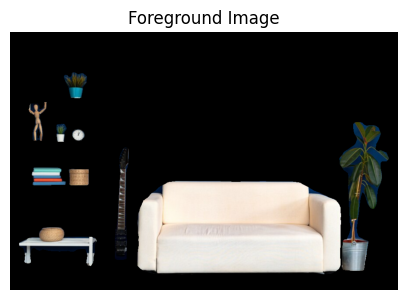

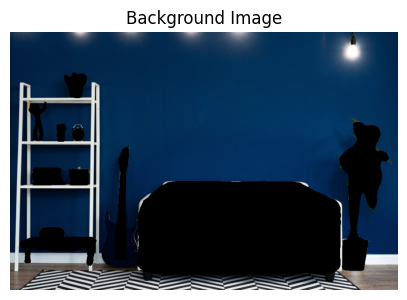

Color Scheme of Foreground - Color 1: RGB(242, 234, 225)
Color Scheme of Foreground - Color 2: RGB(26, 38, 38)
Color Scheme of Foreground - Color 3: RGB(86, 98, 97)
Color Scheme of Foreground - Color 4: RGB(217, 207, 197)
Color Scheme of Foreground - Color 5: RGB(174, 153, 132)


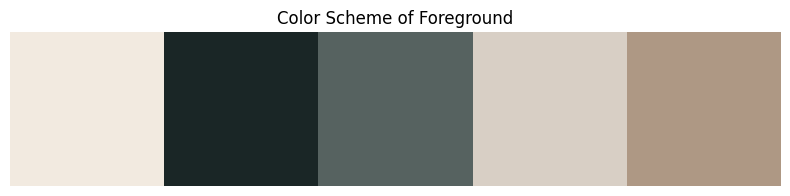

Color Scheme of Background - Color 1: RGB(79, 86, 96)
Color Scheme of Background - Color 2: RGB(215, 219, 219)
Color Scheme of Background - Color 3: RGB(4, 46, 87)
Color Scheme of Background - Color 4: RGB(7, 23, 45)
Color Scheme of Background - Color 5: RGB(145, 145, 146)


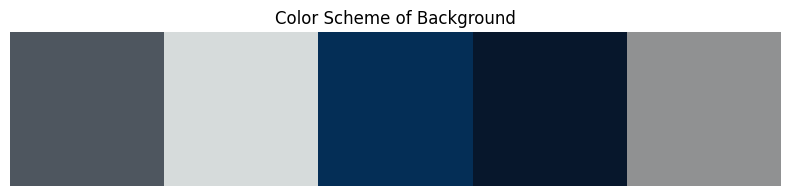

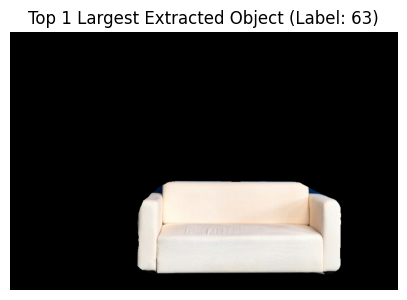

Color Scheme of Top 1 Largest Object - Color 1: RGB(206, 191, 177)
Color Scheme of Top 1 Largest Object - Color 2: RGB(244, 236, 226)
Color Scheme of Top 1 Largest Object - Color 3: RGB(18, 24, 33)
Color Scheme of Top 1 Largest Object - Color 4: RGB(230, 217, 205)
Color Scheme of Top 1 Largest Object - Color 5: RGB(166, 145, 128)


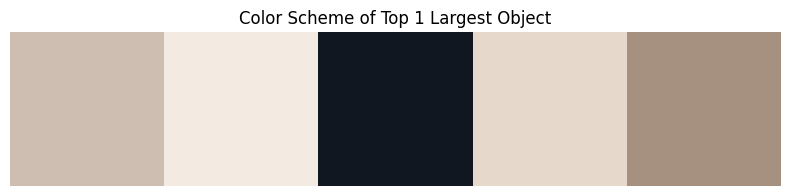

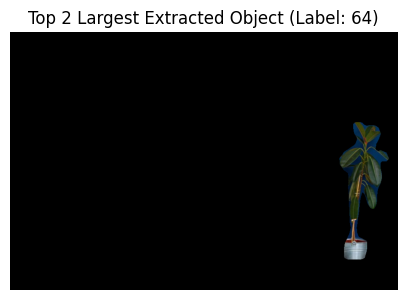

Color Scheme of Top 2 Largest Object - Color 1: RGB(41, 51, 23)
Color Scheme of Top 2 Largest Object - Color 2: RGB(121, 126, 123)
Color Scheme of Top 2 Largest Object - Color 3: RGB(72, 79, 58)
Color Scheme of Top 2 Largest Object - Color 4: RGB(8, 39, 69)
Color Scheme of Top 2 Largest Object - Color 5: RGB(167, 183, 193)


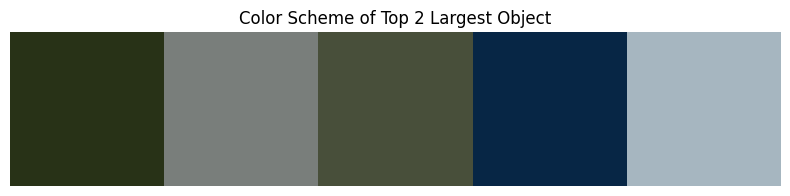

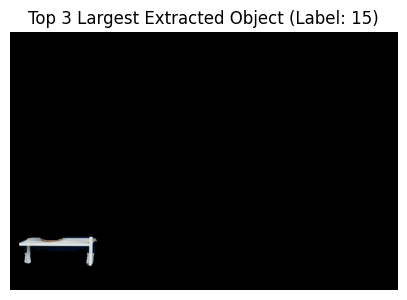

Color Scheme of Top 3 Largest Object - Color 1: RGB(145, 148, 146)
Color Scheme of Top 3 Largest Object - Color 2: RGB(3, 13, 31)
Color Scheme of Top 3 Largest Object - Color 3: RGB(188, 196, 197)
Color Scheme of Top 3 Largest Object - Color 4: RGB(77, 80, 85)
Color Scheme of Top 3 Largest Object - Color 5: RGB(220, 225, 224)


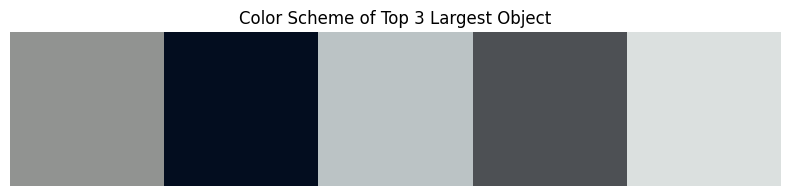

In [5]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision.models as models
import torchvision
import torchvision.ops as ops  # NMS 적용을 위해 추가

# Mask R-CNN 모델 정의 및 로드
class ObjectSegmenter:
    def __init__(self, threshold=0.001, iou_threshold=0.3, brightness_threshold=200):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Pre-trained Mask R-CNN 모델 로드
        self.model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='MaskRCNN_ResNet50_FPN_Weights.COCO_V1')
        self.model.to(self.device)
        self.model.eval()
        self.threshold = threshold
        self.iou_threshold = iou_threshold
        self.brightness_threshold = brightness_threshold  # 밝기 기준 추가
        self.transform = T.Compose([T.ToTensor()])

    def segment_image(self, image_path):
        # 이미지 로드 및 전처리
        image = Image.open(image_path).convert("RGB")
        input_tensor = self.transform(image).unsqueeze(0).to(self.device)

        # 모델 추론
        with torch.no_grad():
            predictions = self.model(input_tensor)

        # 예측 결과에서 마스크와 클래스 추출
        boxes = predictions[0]['boxes']
        masks = predictions[0]['masks']
        labels = predictions[0]['labels']
        scores = predictions[0]['scores']

        # 특정 임계값 이상인 객체들만 선택
        keep = scores >= self.threshold
        boxes = boxes[keep]
        masks = masks[keep]
        labels = labels[keep]
        scores = scores[keep]

        # NMS (Non-Maximum Suppression)를 통해 중복된 객체 필터링
        keep_indices = ops.nms(boxes, scores, self.iou_threshold)
        boxes = boxes[keep_indices]
        masks = masks[keep_indices]
        labels = labels[keep_indices]
        scores = scores[keep_indices]

        # 최종 선택된 객체들의 마스크 및 레이블 저장
        selected_masks = []
        for i in range(len(scores)):
            mask = masks[i, 0].mul(255).byte().cpu().numpy()  # 마스크를 0-255로 스케일링
            selected_masks.append((mask, labels[i].item()))

        return selected_masks, np.array(image)

    def extract_and_visualize_objects(self, image_np, masks):
        # 배경 마스크 초기화 (모든 영역을 배경으로 시작)
        background_mask = np.ones(image_np.shape[:2], dtype=np.uint8) * 255

        # 각 객체의 마스크를 배경에 반영 (배경 마스크 업데이트)
        for mask, _ in masks:
            background_mask[mask > 128] = 0

        # 전경 이미지 생성 (배경을 제외한 나머지를 전경으로 설정)
        foreground_mask = background_mask == 0
        foreground_image = np.zeros_like(image_np)
        foreground_image[foreground_mask] = image_np[foreground_mask]

        # 배경 이미지 생성
        background_image = np.zeros_like(image_np)
        background_mask_bool = background_mask == 255
        background_image[background_mask_bool] = image_np[background_mask_bool]

        # 전경 이미지 시각화
        plt.figure(figsize=(5, 5))
        plt.imshow(foreground_image)
        plt.title("Foreground Image")
        plt.axis('off')
        plt.show()

        # 배경 이미지 시각화
        plt.figure(figsize=(5, 5))
        plt.imshow(background_image)
        plt.title("Background Image")
        plt.axis('off')
        plt.show()

        # 밝은 영역 추가 탐지 (조명과 같은 작은 객체가 놓치는 경우 보완)
        bright_mask = cv2.cvtColor(background_image, cv2.COLOR_RGB2GRAY) > self.brightness_threshold
        bright_extracted_object = np.zeros_like(image_np)
        bright_extracted_object[bright_mask] = image_np[bright_mask]
        
        # 전경 색상 스키마 추출
        foreground_colors = image_np[foreground_mask]
        if len(foreground_colors) > 0:
            kmeans_foreground = KMeans(n_clusters=min(len(foreground_colors), 5)).fit(foreground_colors.reshape(-1, 3))
            foreground_palette = kmeans_foreground.cluster_centers_
        else:
            foreground_palette = np.array([])

        # 배경 색상 스키마 추출
        background_colors = image_np[background_mask_bool]
        if len(background_colors) > 0:
            kmeans_background = KMeans(n_clusters=min(len(background_colors), 5)).fit(background_colors.reshape(-1, 3))
            background_palette = kmeans_background.cluster_centers_
        else:
            background_palette = np.array([])

        # 전경 및 배경 색상 스키마 시각화 및 RGB 값 출력
        self.plot_color_palette_with_rgb(foreground_palette, "Color Scheme of Foreground")
        self.plot_color_palette_with_rgb(background_palette, "Color Scheme of Background")

        # 객체 크기 기준으로 상위 3개 선택
        mask_sizes = [(i, np.sum(mask > 128)) for i, (mask, _) in enumerate(masks)]
        top_3_indices = sorted(mask_sizes, key=lambda x: x[1], reverse=True)[:3]

        # 상위 3개 객체 시각화 및 색상 스키마 추출
        for idx, (i, _) in enumerate(top_3_indices):
            mask, label = masks[i]
            # 객체 마스크에 따른 추출
            object_mask = mask > 128
            extracted_object = np.zeros_like(image_np)
            extracted_object[object_mask] = image_np[object_mask]

            # 추출된 객체 이미지 시각화
            plt.figure(figsize=(5, 5))
            plt.imshow(extracted_object)
            plt.title(f"Top {idx + 1} Largest Extracted Object (Label: {label})")
            plt.axis('off')
            plt.show()

            # 색상 스키마 추출
            object_colors = image_np[object_mask]
            if len(object_colors) > 0:
                kmeans_object = KMeans(n_clusters=min(len(object_colors), 5)).fit(object_colors.reshape(-1, 3))
                object_palette = kmeans_object.cluster_centers_
            else:
                object_palette = np.array([])

            # 색상 스키마 시각화 및 RGB 값 출력
            self.plot_color_palette_with_rgb(object_palette, f"Color Scheme of Top {idx + 1} Largest Object")

    @staticmethod
    def plot_color_palette_with_rgb(colors, title):
        if len(colors) == 0:
            print(f"No colors to display for {title}")
            return
        fig, ax = plt.subplots(1, 1, figsize=(10, 2), subplot_kw=dict(xticks=[], yticks=[], frame_on=False))
        palette = np.zeros((50, len(colors) * 50, 3), dtype=np.uint8)
        for i, color in enumerate(colors):
            palette[:, i * 50:(i + 1) * 50] = color[:3]
            print(f"{title} - Color {i + 1}: RGB({color[0]:.0f}, {color[1]:.0f}, {color[2]:.0f})")
        ax.imshow(palette)
        plt.title(title)
        plt.show()

# ObjectSegmenter 인스턴스 생성 및 객체 분할 수행
segmenter = ObjectSegmenter(threshold=0.001, iou_threshold=0.3, brightness_threshold=230)  # 임계값을 낮추고 밝은 영역 탐지 추가
masks, image_np = segmenter.segment_image("./test_image/img5.png")

# 전경 및 배경의 색상 스키마 시각화 및 RGB 값 출력
segmenter.extract_and_visualize_objects(image_np, masks)


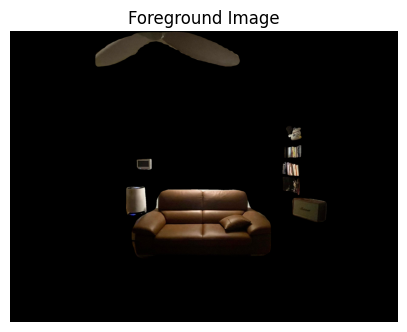

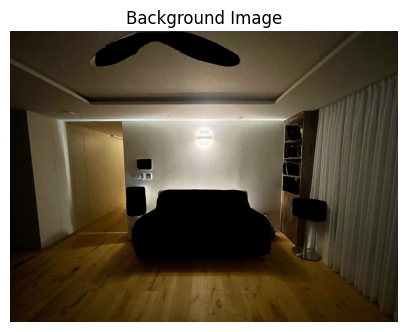

Color Scheme of Foreground - Color 1: RGB(57, 40, 24)
Color Scheme of Foreground - Color 2: RGB(139, 108, 81)
Color Scheme of Foreground - Color 3: RGB(88, 68, 46)
Color Scheme of Foreground - Color 4: RGB(16, 8, 4)
Color Scheme of Foreground - Color 5: RGB(211, 191, 171)


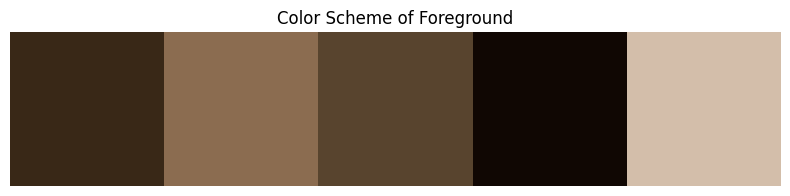

Color Scheme of Background - Color 1: RGB(101, 87, 60)
Color Scheme of Background - Color 2: RGB(34, 23, 8)
Color Scheme of Background - Color 3: RGB(204, 197, 182)
Color Scheme of Background - Color 4: RGB(69, 54, 27)
Color Scheme of Background - Color 5: RGB(145, 132, 107)


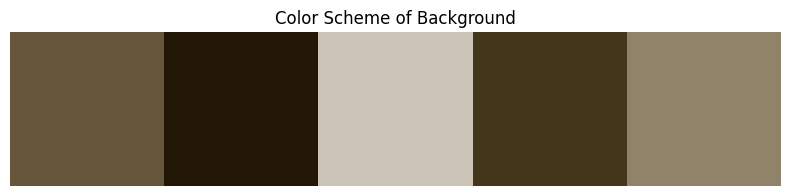

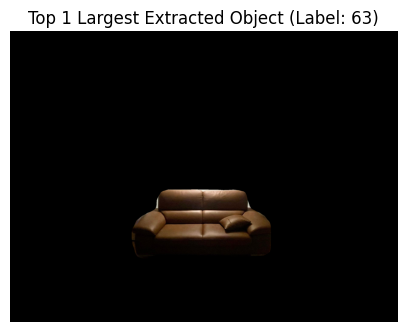

Color Scheme of Top 1 Largest Object - Color 1: RGB(14, 6, 3)
Color Scheme of Top 1 Largest Object - Color 2: RGB(141, 106, 76)
Color Scheme of Top 1 Largest Object - Color 3: RGB(209, 178, 154)
Color Scheme of Top 1 Largest Object - Color 4: RGB(103, 70, 40)
Color Scheme of Top 1 Largest Object - Color 5: RGB(53, 31, 15)


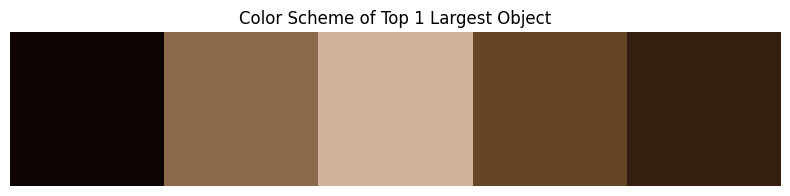

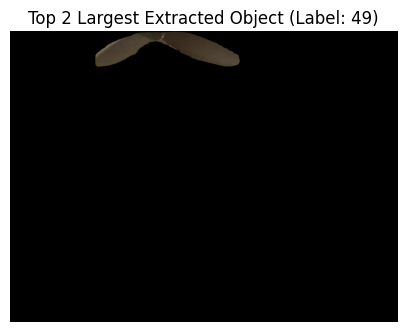

Color Scheme of Top 2 Largest Object - Color 1: RGB(77, 65, 49)
Color Scheme of Top 2 Largest Object - Color 2: RGB(54, 43, 29)
Color Scheme of Top 2 Largest Object - Color 3: RGB(113, 103, 86)
Color Scheme of Top 2 Largest Object - Color 4: RGB(67, 55, 40)
Color Scheme of Top 2 Largest Object - Color 5: RGB(85, 74, 57)


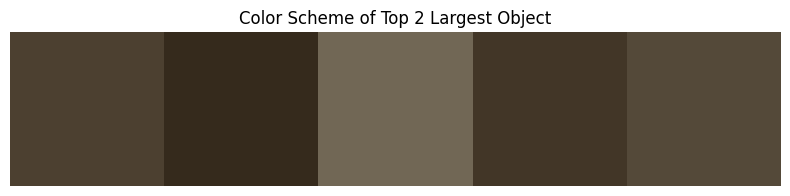

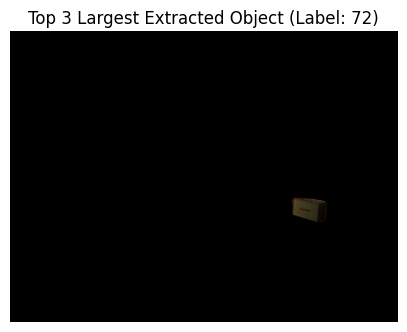

Color Scheme of Top 3 Largest Object - Color 1: RGB(68, 58, 33)
Color Scheme of Top 3 Largest Object - Color 2: RGB(15, 9, 4)
Color Scheme of Top 3 Largest Object - Color 3: RGB(39, 28, 12)
Color Scheme of Top 3 Largest Object - Color 4: RGB(85, 73, 50)
Color Scheme of Top 3 Largest Object - Color 5: RGB(54, 45, 24)


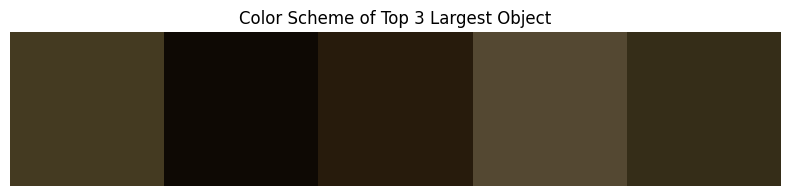

In [8]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision.models as models
import torchvision
import torchvision.ops as ops  # NMS 적용을 위해 추가

# Mask R-CNN 모델 정의 및 로드
class ObjectSegmenter:
    def __init__(self, threshold=0.001, iou_threshold=0.3, brightness_threshold=200):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Pre-trained Mask R-CNN 모델 로드
        self.model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='MaskRCNN_ResNet50_FPN_Weights.COCO_V1')
        self.model.to(self.device)
        self.model.eval()
        self.threshold = threshold
        self.iou_threshold = iou_threshold
        self.brightness_threshold = brightness_threshold  # 밝기 기준 추가
        self.transform = T.Compose([T.ToTensor()])

    def segment_image(self, image_path):
        # 이미지 로드 및 전처리
        image = Image.open(image_path).convert("RGB")
        input_tensor = self.transform(image).unsqueeze(0).to(self.device)

        # 모델 추론
        with torch.no_grad():
            predictions = self.model(input_tensor)

        # 예측 결과에서 마스크와 클래스 추출
        boxes = predictions[0]['boxes']
        masks = predictions[0]['masks']
        labels = predictions[0]['labels']
        scores = predictions[0]['scores']

        # 특정 임계값 이상인 객체들만 선택
        keep = scores >= self.threshold
        boxes = boxes[keep]
        masks = masks[keep]
        labels = labels[keep]
        scores = scores[keep]

        # NMS (Non-Maximum Suppression)를 통해 중복된 객체 필터링
        keep_indices = ops.nms(boxes, scores, self.iou_threshold)
        boxes = boxes[keep_indices]
        masks = masks[keep_indices]
        labels = labels[keep_indices]
        scores = scores[keep_indices]

        # 최종 선택된 객체들의 마스크 및 레이블 저장
        selected_masks = []
        for i in range(len(scores)):
            mask = masks[i, 0].mul(255).byte().cpu().numpy()  # 마스크를 0-255로 스케일링
            selected_masks.append((mask, labels[i].item()))

        return selected_masks, np.array(image)

    def extract_and_visualize_objects(self, image_np, masks):
        # 배경 마스크 초기화 (모든 영역을 배경으로 시작)
        background_mask = np.ones(image_np.shape[:2], dtype=np.uint8) * 255

        # 각 객체의 마스크를 배경에 반영 (배경 마스크 업데이트)
        for mask, _ in masks:
            background_mask[mask > 128] = 0

        # 전경 이미지 생성 (배경을 제외한 나머지를 전경으로 설정)
        foreground_mask = background_mask == 0
        foreground_image = np.zeros_like(image_np)
        foreground_image[foreground_mask] = image_np[foreground_mask]

        # 배경 이미지 생성
        background_image = np.zeros_like(image_np)
        background_mask_bool = background_mask == 255
        background_image[background_mask_bool] = image_np[background_mask_bool]

        # 전경 이미지 시각화
        plt.figure(figsize=(5, 5))
        plt.imshow(foreground_image)
        plt.title("Foreground Image")
        plt.axis('off')
        plt.show()

        # 배경 이미지 시각화
        plt.figure(figsize=(5, 5))
        plt.imshow(background_image)
        plt.title("Background Image")
        plt.axis('off')
        plt.show()

        # 밝은 영역 추가 탐지 (조명과 같은 작은 객체가 놓치는 경우 보완)
        bright_mask = cv2.cvtColor(background_image, cv2.COLOR_RGB2GRAY) > self.brightness_threshold
        bright_extracted_object = np.zeros_like(image_np)
        bright_extracted_object[bright_mask] = image_np[bright_mask]
        
        # 전경 색상 스키마 추출
        foreground_colors = image_np[foreground_mask]
        if len(foreground_colors) > 0:
            kmeans_foreground = KMeans(n_clusters=min(len(foreground_colors), 5)).fit(foreground_colors.reshape(-1, 3))
            foreground_palette = kmeans_foreground.cluster_centers_
        else:
            foreground_palette = np.array([])

        # 배경 색상 스키마 추출
        background_colors = image_np[background_mask_bool]
        if len(background_colors) > 0:
            kmeans_background = KMeans(n_clusters=min(len(background_colors), 5)).fit(background_colors.reshape(-1, 3))
            background_palette = kmeans_background.cluster_centers_
        else:
            background_palette = np.array([])

        # 전경 및 배경 색상 스키마 시각화 및 RGB 값 출력
        self.plot_color_palette_with_rgb(foreground_palette, "Color Scheme of Foreground")
        self.plot_color_palette_with_rgb(background_palette, "Color Scheme of Background")

        # 객체 크기 기준으로 상위 3개 선택
        mask_sizes = [(i, np.sum(mask > 128)) for i, (mask, _) in enumerate(masks)]
        top_3_indices = sorted(mask_sizes, key=lambda x: x[1], reverse=True)[:3]

        # 상위 3개 객체 시각화 및 색상 스키마 추출
        for idx, (i, _) in enumerate(top_3_indices):
            mask, label = masks[i]
            # 객체 마스크에 따른 추출
            object_mask = mask > 128
            extracted_object = np.zeros_like(image_np)
            extracted_object[object_mask] = image_np[object_mask]

            # 추출된 객체 이미지 시각화
            plt.figure(figsize=(5, 5))
            plt.imshow(extracted_object)
            plt.title(f"Top {idx + 1} Largest Extracted Object (Label: {label})")
            plt.axis('off')
            plt.show()

            # 색상 스키마 추출
            object_colors = image_np[object_mask]
            if len(object_colors) > 0:
                kmeans_object = KMeans(n_clusters=min(len(object_colors), 5)).fit(object_colors.reshape(-1, 3))
                object_palette = kmeans_object.cluster_centers_
            else:
                object_palette = np.array([])

            # 색상 스키마 시각화 및 RGB 값 출력
            self.plot_color_palette_with_rgb(object_palette, f"Color Scheme of Top {idx + 1} Largest Object")

    @staticmethod
    def plot_color_palette_with_rgb(colors, title):
        if len(colors) == 0:
            print(f"No colors to display for {title}")
            return
        fig, ax = plt.subplots(1, 1, figsize=(10, 2), subplot_kw=dict(xticks=[], yticks=[], frame_on=False))
        palette = np.zeros((50, len(colors) * 50, 3), dtype=np.uint8)
        for i, color in enumerate(colors):
            palette[:, i * 50:(i + 1) * 50] = color[:3]
            print(f"{title} - Color {i + 1}: RGB({color[0]:.0f}, {color[1]:.0f}, {color[2]:.0f})")
        ax.imshow(palette)
        plt.title(title)
        plt.show()

# ObjectSegmenter 인스턴스 생성 및 객체 분할 수행
segmenter = ObjectSegmenter(threshold=0.001, iou_threshold=0.3, brightness_threshold=230)  # 임계값을 낮추고 밝은 영역 탐지 추가
masks, image_np = segmenter.segment_image("./test_image/img25.jpg")

# 전경 및 배경의 색상 스키마 시각화 및 RGB 값 출력
segmenter.extract_and_visualize_objects(image_np, masks)


Foreground Color Palette with Weights:
Color 1: RGB(242, 235, 225), Weight: 0.53
Color 2: RGB(26, 38, 38), Weight: 0.17
Color 3: RGB(174, 153, 133), Weight: 0.07
Color 4: RGB(87, 98, 97), Weight: 0.07
Color 5: RGB(217, 208, 198), Weight: 0.15
     Color                 RGB Weight
0  Color 1  RGB(242, 235, 225)   0.53
1  Color 2     RGB(26, 38, 38)   0.17
2  Color 3  RGB(174, 153, 133)   0.07
3  Color 4     RGB(87, 98, 97)   0.07
4  Color 5  RGB(217, 208, 198)   0.15
Background Color Palette with Weights:
Color 1: RGB(4, 46, 87), Weight: 0.67
Color 2: RGB(215, 219, 219), Weight: 0.07
Color 3: RGB(145, 145, 146), Weight: 0.04
Color 4: RGB(7, 23, 45), Weight: 0.17
Color 5: RGB(79, 86, 96), Weight: 0.05
     Color                 RGB Weight
0  Color 1      RGB(4, 46, 87)   0.67
1  Color 2  RGB(215, 219, 219)   0.07
2  Color 3  RGB(145, 145, 146)   0.04
3  Color 4      RGB(7, 23, 45)   0.17
4  Color 5     RGB(79, 86, 96)   0.05


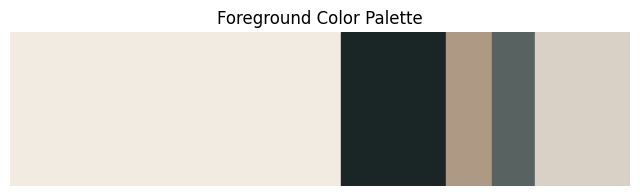

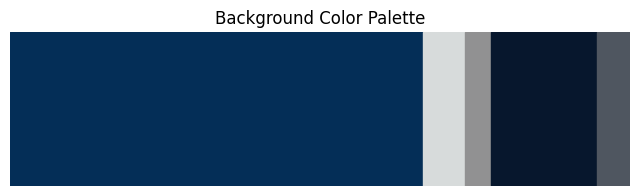

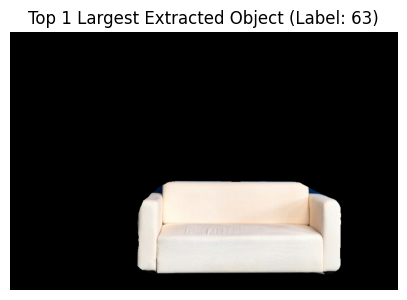

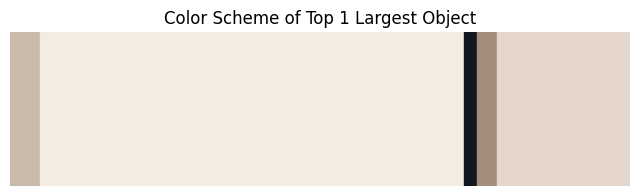

Top 1 Largest Object (Label: 63) occupies 17.75% of the image.


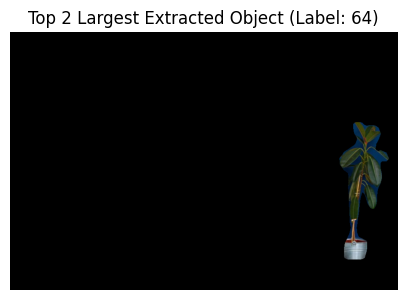

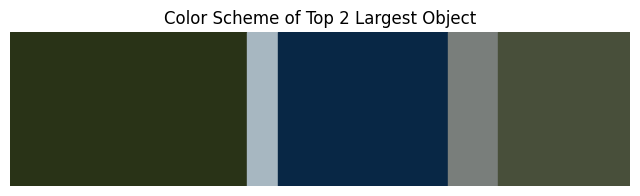

Top 2 Largest Object (Label: 64) occupies 3.24% of the image.


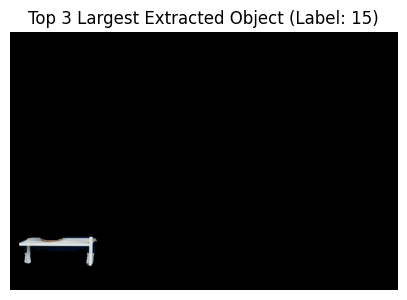

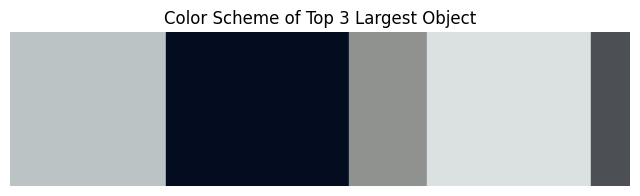

Top 3 Largest Object (Label: 15) occupies 1.08% of the image.


In [9]:
import cv2
import numpy as np
import os
import csv
from sklearn.cluster import KMeans
from PIL import Image
import torch
import torchvision.transforms as T
import torchvision
import torchvision.ops as ops  # NMS 적용을 위해 추가
import matplotlib.pyplot as plt
import pandas as pd
import random

import torch.backends.cudnn as cudnn

# 시드 고정 함수 수정
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        cudnn.deterministic = True
        cudnn.benchmark = False
        
# Mask R-CNN 모델 정의 및 로드
class ObjectSegmenter:
    def __init__(self, threshold=0.001, iou_threshold=0.3, brightness_threshold=200):
        set_seed()  # 시드 고정
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Pre-trained Mask R-CNN 모델 로드
        self.model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='MaskRCNN_ResNet50_FPN_Weights.COCO_V1')
        self.model.to(self.device)
        self.model.eval()
        self.threshold = threshold
        self.iou_threshold = iou_threshold
        self.brightness_threshold = brightness_threshold  # 밝기 기준 추가
        self.transform = T.Compose([T.ToTensor()])

    def segment_image(self, image_path):
        # 이미지 로드 및 전처리
        image = Image.open(image_path).convert("RGB")
        input_tensor = self.transform(image).unsqueeze(0).to(self.device)

        # 모델 추론
        with torch.no_grad():
            predictions = self.model(input_tensor)

        # 예측 결과에서 마스크와 클래스 추출
        boxes = predictions[0]['boxes']
        masks = predictions[0]['masks']
        labels = predictions[0]['labels']
        scores = predictions[0]['scores']

        # 특정 임계값 이상인 객체들만 선택
        keep = scores >= self.threshold
        boxes = boxes[keep]
        masks = masks[keep]
        labels = labels[keep]
        scores = scores[keep]

        # NMS (Non-Maximum Suppression)를 통해 중복된 객체 필터링
        keep_indices = ops.nms(boxes, scores, self.iou_threshold)
        boxes = boxes[keep_indices]
        masks = masks[keep_indices]
        labels = labels[keep_indices]
        scores = scores[keep_indices]

        # 최종 선택된 객체들의 마스크 및 레이블 저장
        selected_masks = []
        for i in range(len(scores)):
            mask = masks[i, 0].mul(255).byte().cpu().numpy()  # 마스크를 0-255로 스케일링
            selected_masks.append((mask, labels[i].item(), boxes[i]))

        return selected_masks, np.array(image)

    def extract_and_save_objects(self, image_np, masks, bright_objects_folder):
        # 배경 마스크 초기화 (모든 영역을 배경으로 시작)
        background_mask = np.ones(image_np.shape[:2], dtype=np.uint8) * 255

        # 각 객체의 마스크를 배경에 반영 (배경 마스크 업데이트)
        for mask, _, _ in masks:
            background_mask[mask > 128] = 0

        # 전경 이미지 생성 (배경을 제외한 나머지를 전경으로 설정)
        foreground_mask = background_mask == 0
        foreground_image = np.zeros_like(image_np)
        foreground_image[foreground_mask] = image_np[foreground_mask]

        # 밝은 영역 추가 탐지 (조명과 같은 작은 객체가 놓치는 경우 보완)
        bright_mask = cv2.cvtColor(foreground_image, cv2.COLOR_RGB2GRAY) > self.brightness_threshold
        bright_extracted_object = np.zeros_like(image_np)
        bright_extracted_object[bright_mask] = image_np[bright_mask]

        # 밝은 영역 이미지 저장 (조명 추출)
        if np.any(bright_mask):
            if not os.path.exists(bright_objects_folder):
                os.makedirs(bright_objects_folder)
            bright_image_path = os.path.join(bright_objects_folder, "bright_object.png")
            Image.fromarray(bright_extracted_object).save(bright_image_path)

        # 전경 및 배경 색상 스키마 추출 및 가중치 계산
        foreground_colors, foreground_weights = self.calculate_color_palette_with_weights(foreground_mask, image_np)
        background_colors, background_weights = self.calculate_color_palette_with_weights(background_mask == 255, image_np)

        # 전경 및 배경 색상 스키마 출력
        self.print_palette_with_weights(foreground_colors, foreground_weights, "Foreground")
        self.print_palette_with_weights(background_colors, background_weights, "Background")
        self.plot_palette_with_weights(foreground_colors, foreground_weights, "Foreground Color Palette")
        self.plot_palette_with_weights(background_colors, background_weights, "Background Color Palette")

        # 상위 3개 객체 추출 및 비율 계산
        mask_areas = [(i, np.sum(mask > 128)) for i, (mask, _, _) in enumerate(masks)]
        top_3_masks = sorted(mask_areas, key=lambda x: x[1], reverse=True)[:3]

        for idx, (i, area) in enumerate(top_3_masks):
            mask, label, box = masks[i]
            # 객체 마스크에 따른 추출
            object_mask = mask > 128
            extracted_object = np.zeros_like(image_np)
            extracted_object[object_mask] = image_np[object_mask]

            # 추출된 객체 이미지 시각화
            plt.figure(figsize=(5, 5))
            plt.imshow(extracted_object)
            plt.title(f"Top {idx + 1} Largest Extracted Object (Label: {label})")
            plt.axis('off')
            plt.show()

            # 색상 스키마 추출
            object_colors = image_np[object_mask]
            if len(object_colors) > 0:
                kmeans_object = KMeans(n_clusters=min(len(object_colors), 5)).fit(object_colors.reshape(-1, 3))
                object_palette = kmeans_object.cluster_centers_
                object_weights = np.bincount(kmeans_object.labels_) / len(kmeans_object.labels_)
            else:
                object_palette = np.array([])
                object_weights = np.array([])

            # 색상 스키마 시각화 및 RGB 값 출력
            self.plot_palette_with_weights(object_palette, object_weights, f"Color Scheme of Top {idx + 1} Largest Object")

            # 객체가 이미지에서 차지하는 비율 계산 및 출력
            image_area = image_np.shape[0] * image_np.shape[1]
            object_ratio = area / image_area
            print(f"Top {idx + 1} Largest Object (Label: {label}) occupies {object_ratio:.2%} of the image.")

    def calculate_color_palette_with_weights(self, mask, image_np):
        # 마스크로부터 해당되는 색상 추출
        colors = image_np[mask]

        if len(colors) > 0:
            # KMeans를 이용해 클러스터링 및 가중치 계산
            kmeans = KMeans(n_clusters=min(len(colors), 5), random_state=42).fit(colors.reshape(-1, 3))
            unique_labels, counts = np.unique(kmeans.labels_, return_counts=True)
            weights = counts / counts.sum()  # 각 클러스터의 픽셀 수를 가중치로 사용
            return kmeans.cluster_centers_, weights
        else:
            return np.array([]), np.array([])

    def print_palette_with_weights(self, colors, weights, label):
        if len(colors) == 0:
            print(f"No colors to display for {label}")
            return

        print(f"{label} Color Palette with Weights:")
        data = []
        for i, (color, weight) in enumerate(zip(colors, weights)):
            print(f"Color {i + 1}: RGB({color[0]:.0f}, {color[1]:.0f}, {color[2]:.0f}), Weight: {weight:.2f}")
            data.append([f"Color {i + 1}", f"RGB({color[0]:.0f}, {color[1]:.0f}, {color[2]:.0f})", f"{weight:.2f}"])
        df = pd.DataFrame(data, columns=["Color", "RGB", "Weight"])
        print(df)

    def plot_palette_with_weights(self, colors, weights, title):
        if len(colors) == 0:
            print(f"No colors to display for {title}")
            return

        total_weight = np.sum(weights)
        fig, ax = plt.subplots(1, 1, figsize=(8, 2))
        current_x = 0

        for i, (color, weight) in enumerate(zip(colors, weights)):
            width = weight / total_weight  # 가중치에 비례한 너비
            ax.add_patch(plt.Rectangle((current_x, 0), width, 1, color=color / 255.0))
            current_x += width

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')
        ax.set_title(title)
        plt.show()


# 이미지 파일 경로 정의
image_path = "./test_image/img5.png"

# 밝은 객체를 저장할 폴더 정의
bright_objects_folder = "./bright_objects/"

# ObjectSegmenter 인스턴스 생성 및 객체 분할 수행
segmenter = ObjectSegmenter(threshold=0.001, iou_threshold=0.3, brightness_threshold=230)
masks, image_np = segmenter.segment_image(image_path)

# 전경 및 배경의 색상 스키마와 가중치 출력 및 밝은 객체 저장
segmenter.extract_and_save_objects(image_np, masks, bright_objects_folder)


In [ ]:
import cv2
import numpy as np
import os
import csv
from sklearn.cluster import KMeans
from PIL import Image
import torch
import torchvision.transforms as T
import torchvision
import torchvision.ops as ops  # NMS 적용을 위해 추가
import matplotlib.pyplot as plt
import pandas as pd
import random

import torch.backends.cudnn as cudnn

# 시드 고정 함수 수정
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        cudnn.deterministic = True
        cudnn.benchmark = False
        
# 시드 고정
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Mask R-CNN 모델 정의 및 로드
class ObjectSegmenter:
    def __init__(self, threshold=0.001, iou_threshold=0.3, brightness_threshold=200):
        set_seed()  # 시드 고정
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Pre-trained Mask R-CNN 모델 로드
        self.model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='MaskRCNN_ResNet50_FPN_Weights.COCO_V1')
        self.model.to(self.device)
        self.model.eval()
        self.threshold = threshold
        self.iou_threshold = iou_threshold
        self.brightness_threshold = brightness_threshold  # 밝기 기준 추가
        self.transform = T.Compose([T.ToTensor()])

    def segment_image(self, image_path):
        # 이미지 로드 및 전처리
        image = Image.open(image_path).convert("RGB")
        input_tensor = self.transform(image).unsqueeze(0).to(self.device)

        # 모델 추론
        with torch.no_grad():
            predictions = self.model(input_tensor)

        # 예측 결과에서 마스크와 클래스 추출
        boxes = predictions[0]['boxes']
        masks = predictions[0]['masks']
        labels = predictions[0]['labels']
        scores = predictions[0]['scores']

        # 특정 임계값 이상인 객체들만 선택
        keep = scores >= self.threshold
        boxes = boxes[keep]
        masks = masks[keep]
        labels = labels[keep]
        scores = scores[keep]

        # NMS (Non-Maximum Suppression)를 통해 중복된 객체 필터링
        keep_indices = ops.nms(boxes, scores, self.iou_threshold)
        boxes = boxes[keep_indices]
        masks = masks[keep_indices]
        labels = labels[keep_indices]
        scores = scores[keep_indices]

        # 최종 선택된 객체들의 마스크 및 레이블 저장
        selected_masks = []
        for i in range(len(scores)):
            mask = masks[i, 0].mul(255).byte().cpu().numpy()  # 마스크를 0-255로 스케일링
            selected_masks.append((mask, labels[i].item()))

        return selected_masks, np.array(image)

    def extract_and_save_objects(self, image_np, masks, bright_objects_folder):
        # 배경 마스크 초기화 (모든 영역을 배경으로 시작)
        background_mask = np.ones(image_np.shape[:2], dtype=np.uint8) * 255

        # 각 객체의 마스크를 배경에 반영 (배경 마스크 업데이트)
        for mask, _ in masks:
            background_mask[mask > 128] = 0

        # 전경 이미지 생성 (배경을 제외한 나머지를 전경으로 설정)
        foreground_mask = background_mask == 0
        foreground_image = np.zeros_like(image_np)
        foreground_image[foreground_mask] = image_np[foreground_mask]

        # 배경 이미지 생성
        background_image = np.zeros_like(image_np)
        background_mask_bool = background_mask == 255
        background_image[background_mask_bool] = image_np[background_mask_bool]

        # 전경 이미지 시각화
        plt.figure(figsize=(5, 5))
        plt.imshow(foreground_image)
        plt.title("Foreground Image")
        plt.axis('off')
        plt.show()

        # 배경 이미지 시각화
        plt.figure(figsize=(5, 5))
        plt.imshow(background_image)
        plt.title("Background Image")
        plt.axis('off')
        plt.show()

        # 밝은 영역 추가 탐지 (조명과 같은 작은 객체가 놓치는 경우 보완)
        bright_mask = cv2.cvtColor(foreground_image, cv2.COLOR_RGB2GRAY) > self.brightness_threshold
        bright_extracted_object = np.zeros_like(image_np)
        bright_extracted_object[bright_mask] = image_np[bright_mask]

        # 밝은 영역 이미지 저장 (조명 추출)
        if np.any(bright_mask):
            if not os.path.exists(bright_objects_folder):
                os.makedirs(bright_objects_folder)
            bright_image_path = os.path.join(bright_objects_folder, "bright_object.png")
            Image.fromarray(bright_extracted_object).save(bright_image_path)

        # 전경 및 배경 색상 스키마 추출 및 가중치 계산
        foreground_colors, foreground_weights = self.calculate_color_palette_with_weights(foreground_mask, image_np)
        background_colors, background_weights = self.calculate_color_palette_with_weights(background_mask == 255, image_np)

        # 전경 및 배경 색상 스키마 출력
        self.print_palette_with_weights(foreground_colors, foreground_weights, "Foreground")
        self.print_palette_with_weights(background_colors, background_weights, "Background")
        self.plot_palette_with_weights(foreground_colors, foreground_weights, "Foreground Color Palette")
        self.plot_palette_with_weights(background_colors, background_weights, "Background Color Palette")

        # 객체 크기 기준으로 상위 3개 선택
        mask_sizes = [(i, np.sum(mask > 128)) for i, (mask, _) in enumerate(masks)]
        top_3_indices = sorted(mask_sizes, key=lambda x: x[1], reverse=True)[:3]

        # 상위 3개 객체 시각화 및 색상 스키마 추출
        for idx, (i, size) in enumerate(top_3_indices):
            mask, label = masks[i]
            # 객체 마스크에 따른 추출
            object_mask = mask > 128
            extracted_object = np.zeros_like(image_np)
            extracted_object[object_mask] = image_np[object_mask]

            # 추출된 객체 이미지 시각화
            plt.figure(figsize=(5, 5))
            plt.imshow(extracted_object)
            plt.title(f"Top {idx + 1} Largest Extracted Object (Label: {label})")
            plt.axis('off')
            plt.show()

            # 색상 스키마 추출
            object_colors = image_np[object_mask]
            if len(object_colors) > 0:
                kmeans_object = KMeans(n_clusters=min(len(object_colors), 5)).fit(object_colors.reshape(-1, 3))
                object_palette = kmeans_object.cluster_centers_
            else:
                object_palette = np.array([])

            # 색상 스키마 시각화 및 RGB 값 출력
            self.plot_color_palette_with_rgb(object_palette, f"Color Scheme of Top {idx + 1} Largest Object")

            # 이미지 내에서 객체가 차지하는 비율 계산 및 출력
            total_pixels = image_np.shape[0] * image_np.shape[1]
            object_ratio = size / total_pixels
            print(f"Top {idx + 1} Largest Object (Label: {label}) - Ratio in Image: {object_ratio:.2%}")

    def calculate_color_palette_with_weights(self, mask, image_np):
        # 마스크로부터 해당되는 색상 추출
        colors = image_np[mask]

        if len(colors) > 0:
            # KMeans를 이용해 클러스터링 및 가중치 계산
            kmeans = KMeans(n_clusters=min(len(colors), 5), random_state=42).fit(colors.reshape(-1, 3))
            unique_labels, counts = np.unique(kmeans.labels_, return_counts=True)
            weights = counts / counts.sum()  # 각 클러스터의 픽셀 수를 가중치로 사용
            return kmeans.cluster_centers_, weights
        else:
            return np.array([]), np.array([])

    def print_palette_with_weights(self, colors, weights, label):
        if len(colors) == 0:
            print(f"No colors to display for {label}")
            return

        print(f"{label} Color Palette with Weights:")
        data = []
        for i, (color, weight) in enumerate(zip(colors, weights)):
            print(f"Color {i + 1}: RGB({color[0]:.0f}, {color[1]:.0f}, {color[2]:.0f}), Weight: {weight:.2f}")
            data.append([f"Color {i + 1}", f"RGB({color[0]:.0f}, {color[1]:.0f}, {color[2]:.0f})", f"{weight:.2f}"])
        df = pd.DataFrame(data, columns=["Color", "RGB", "Weight"])
        print(df)

    def plot_palette_with_weights(self, colors, weights, title):
        if len(colors) == 0:
            print(f"No colors to display for {title}")
            return

        total_weight = np.sum(weights)
        fig, ax = plt.subplots(1, 1, figsize=(8, 2))
        current_x = 0

        for i, (color, weight) in enumerate(zip(colors, weights)):
            width = weight / total_weight  # 가중치에 비례한 너비
            ax.add_patch(plt.Rectangle((current_x, 0), width, 1, color=color / 255.0))
            current_x += width

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')
        ax.set_title(title)
        plt.show()


# 이미지 파일 경로 정의
image_path = "./test_image/img5.png"

# 밝은 객체를 저장할 폴더 정의
bright_objects_folder = "./bright_objects/"

# ObjectSegmenter 인스턴스 생성 및 객체 분할 수행
segmenter = ObjectSegmenter(threshold=0.001, iou_threshold=0.3, brightness_threshold=230)
masks, image_np = segmenter.segment_image(image_path)

# 전경 및 배경의 색상 스키마와 가중치 출력 및 밝은 객체 저장
segmenter.extract_and_save_objects(image_np, masks, bright_objects_folder)


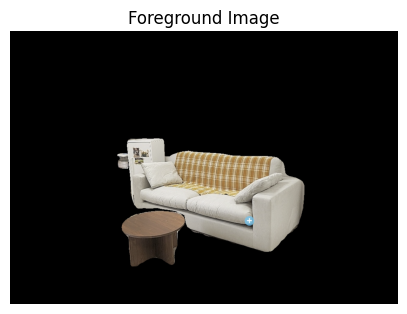

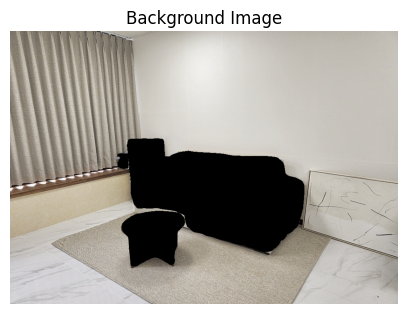

Foreground Color Palette with Weights:
Color 1: RGB(220, 216, 206), Weight: 0.23
Color 2: RGB(141, 117, 87), Weight: 0.18
Color 3: RGB(167, 153, 130), Weight: 0.17
Color 4: RGB(63, 51, 41), Weight: 0.10
Color 5: RGB(186, 180, 166), Weight: 0.31
     Color                 RGB Weight
0  Color 1  RGB(220, 216, 206)   0.23
1  Color 2   RGB(141, 117, 87)   0.18
2  Color 3  RGB(167, 153, 130)   0.17
3  Color 4     RGB(63, 51, 41)   0.10
4  Color 5  RGB(186, 180, 166)   0.31
Background Color Palette with Weights:
Color 1: RGB(217, 214, 210), Weight: 0.24
Color 2: RGB(133, 124, 110), Weight: 0.13
Color 3: RGB(197, 192, 183), Weight: 0.43
Color 4: RGB(171, 163, 149), Weight: 0.17
Color 5: RGB(82, 69, 57), Weight: 0.02
     Color                 RGB Weight
0  Color 1  RGB(217, 214, 210)   0.24
1  Color 2  RGB(133, 124, 110)   0.13
2  Color 3  RGB(197, 192, 183)   0.43
3  Color 4  RGB(171, 163, 149)   0.17
4  Color 5     RGB(82, 69, 57)   0.02


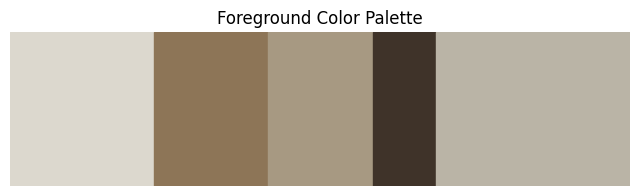

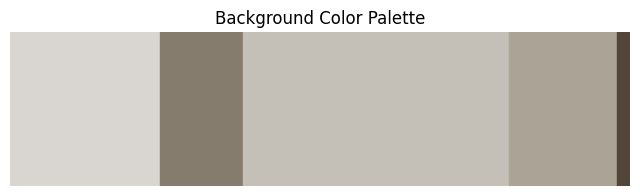

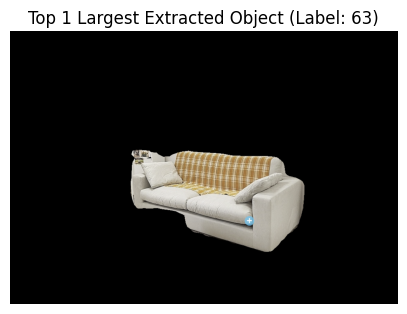

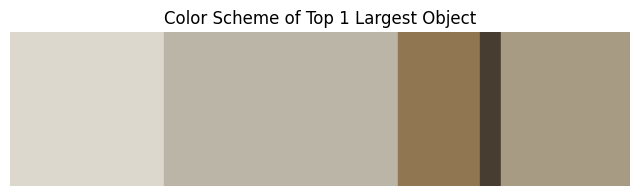

Top 1 Largest Object (Label: 63) occupies 11.93% of the image.


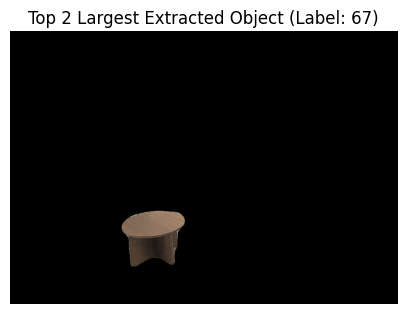

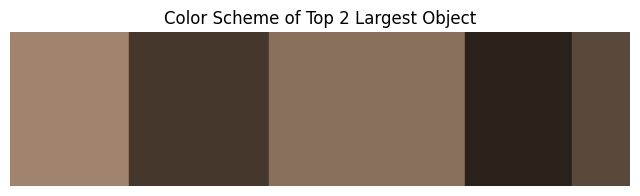

Top 2 Largest Object (Label: 67) occupies 2.42% of the image.


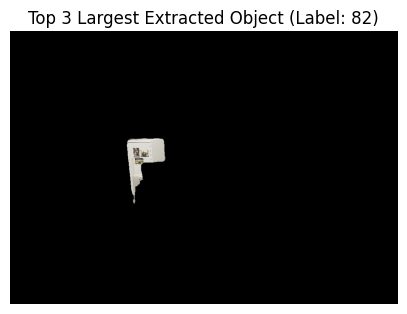

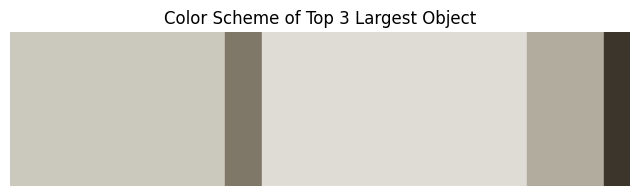

Top 3 Largest Object (Label: 82) occupies 1.12% of the image.


In [17]:
import cv2
import numpy as np
import os
import csv
from sklearn.cluster import KMeans
from PIL import Image
import torch
import torchvision.transforms as T
import torchvision
import torchvision.ops as ops  # NMS 적용을 위해 추가
import matplotlib.pyplot as plt
import pandas as pd
import random

import torch.backends.cudnn as cudnn

# 시드 고정 함수 수정
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        cudnn.deterministic = True
        cudnn.benchmark = False
        
# Mask R-CNN 모델 정의 및 로드
class ObjectSegmenter:
    def __init__(self, threshold=0.001, iou_threshold=0.3, brightness_threshold=200):
        set_seed()  # 시드 고정
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Pre-trained Mask R-CNN 모델 로드
        self.model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='MaskRCNN_ResNet50_FPN_Weights.COCO_V1')
        self.model.to(self.device)
        self.model.eval()
        self.threshold = threshold
        self.iou_threshold = iou_threshold
        self.brightness_threshold = brightness_threshold  # 밝기 기준 추가
        self.transform = T.Compose([T.ToTensor()])

    def segment_image(self, image_path):
        # 이미지 로드 및 전처리
        image = Image.open(image_path).convert("RGB")
        input_tensor = self.transform(image).unsqueeze(0).to(self.device)

        # 모델 추론
        with torch.no_grad():
            predictions = self.model(input_tensor)

        # 예측 결과에서 마스크와 클래스 추출
        boxes = predictions[0]['boxes']
        masks = predictions[0]['masks']
        labels = predictions[0]['labels']
        scores = predictions[0]['scores']

        # 특정 임계값 이상인 객체들만 선택
        keep = scores >= self.threshold
        boxes = boxes[keep]
        masks = masks[keep]
        labels = labels[keep]
        scores = scores[keep]

        # NMS (Non-Maximum Suppression)를 통해 중복된 객체 필터링
        keep_indices = ops.nms(boxes, scores, self.iou_threshold)
        boxes = boxes[keep_indices]
        masks = masks[keep_indices]
        labels = labels[keep_indices]
        scores = scores[keep_indices]

        # 최종 선택된 객체들의 마스크 및 레이블 저장
        selected_masks = []
        for i in range(len(scores)):
            mask = masks[i, 0].mul(255).byte().cpu().numpy()  # 마스크를 0-255로 스케일링
            selected_masks.append((mask, labels[i].item(), boxes[i]))

        return selected_masks, np.array(image)

    def extract_and_save_objects(self, image_np, masks, bright_objects_folder):
        # 배경 마스크 초기화 (모든 영역을 배경으로 시작)
        background_mask = np.ones(image_np.shape[:2], dtype=np.uint8) * 255

        # 각 객체의 마스크를 배경에 반영 (배경 마스크 업데이트)
        for mask, _, _ in masks:
            background_mask[mask > 128] = 0

        # 전경 이미지 생성 (배경을 제외한 나머지를 전경으로 설정)
        foreground_mask = background_mask == 0
        foreground_image = np.zeros_like(image_np)
        foreground_image[foreground_mask] = image_np[foreground_mask]

        # 밝은 영역 추가 탐지 (조명과 같은 작은 객체가 놓치는 경우 보완)
        bright_mask = cv2.cvtColor(foreground_image, cv2.COLOR_RGB2GRAY) > self.brightness_threshold
        bright_extracted_object = np.zeros_like(image_np)
        bright_extracted_object[bright_mask] = image_np[bright_mask]

        # 전경 이미지 시각화
        plt.figure(figsize=(5, 5))
        plt.imshow(foreground_image)
        plt.title("Foreground Image")
        plt.axis('off')
        plt.show()

        # 배경 이미지 생성
        background_image = np.zeros_like(image_np)
        background_mask_bool = background_mask == 255
        background_image[background_mask_bool] = image_np[background_mask_bool]

        # 배경 이미지 시각화
        plt.figure(figsize=(5, 5))
        plt.imshow(background_image)
        plt.title("Background Image")
        plt.axis('off')
        plt.show()

        # 전경 및 배경 색상 스키마 추출 및 가중치 계산
        foreground_colors, foreground_weights = self.calculate_color_palette_with_weights(foreground_mask, image_np)
        background_colors, background_weights = self.calculate_color_palette_with_weights(background_mask == 255, image_np)

        # 전경 및 배경 색상 스키마 출력
        self.print_palette_with_weights(foreground_colors, foreground_weights, "Foreground")
        self.print_palette_with_weights(background_colors, background_weights, "Background")
        self.plot_palette_with_weights(foreground_colors, foreground_weights, "Foreground Color Palette")
        self.plot_palette_with_weights(background_colors, background_weights, "Background Color Palette")

        # 상위 3개 객체 추출 및 비율 계산
        mask_areas = [(i, np.sum(mask > 128)) for i, (mask, _, _) in enumerate(masks)]
        top_3_masks = sorted(mask_areas, key=lambda x: x[1], reverse=True)[:3]

        for idx, (i, area) in enumerate(top_3_masks):
            mask, label, box = masks[i]
            # 객체 마스크에 따른 추출
            object_mask = mask > 128
            extracted_object = np.zeros_like(image_np)
            extracted_object[object_mask] = image_np[object_mask]

            # 추출된 객체 이미지 시각화
            plt.figure(figsize=(5, 5))
            plt.imshow(extracted_object)
            plt.title(f"Top {idx + 1} Largest Extracted Object (Label: {label})")
            plt.axis('off')
            plt.show()

            # 색상 스키마 추출
            object_colors = image_np[object_mask]
            if len(object_colors) > 0:
                kmeans_object = KMeans(n_clusters=min(len(object_colors), 5)).fit(object_colors.reshape(-1, 3))
                object_palette = kmeans_object.cluster_centers_
                object_weights = np.bincount(kmeans_object.labels_) / len(kmeans_object.labels_)
            else:
                object_palette = np.array([])
                object_weights = np.array([])

            # 색상 스키마 시각화 및 RGB 값 출력
            self.plot_palette_with_weights(object_palette, object_weights, f"Color Scheme of Top {idx + 1} Largest Object")

            # 객체가 이미지에서 차지하는 비율 계산 및 출력
            image_area = image_np.shape[0] * image_np.shape[1]
            object_ratio = area / image_area
            print(f"Top {idx + 1} Largest Object (Label: {label}) occupies {object_ratio:.2%} of the image.")

    def calculate_color_palette_with_weights(self, mask, image_np):
        # 마스크로부터 해당되는 색상 추출
        colors = image_np[mask]

        if len(colors) > 0:
            # KMeans를 이용해 클러스터링 및 가중치 계산
            kmeans = KMeans(n_clusters=min(len(colors), 5), random_state=42).fit(colors.reshape(-1, 3))
            unique_labels, counts = np.unique(kmeans.labels_, return_counts=True)
            weights = counts / counts.sum()  # 각 클러스터의 픽셀 수를 가중치로 사용
            return kmeans.cluster_centers_, weights
        else:
            return np.array([]), np.array([])

    def print_palette_with_weights(self, colors, weights, label):
        if len(colors) == 0:
            print(f"No colors to display for {label}")
            return

        print(f"{label} Color Palette with Weights:")
        data = []
        for i, (color, weight) in enumerate(zip(colors, weights)):
            print(f"Color {i + 1}: RGB({color[0]:.0f}, {color[1]:.0f}, {color[2]:.0f}), Weight: {weight:.2f}")
            data.append([f"Color {i + 1}", f"RGB({color[0]:.0f}, {color[1]:.0f}, {color[2]:.0f})", f"{weight:.2f}"])
        df = pd.DataFrame(data, columns=["Color", "RGB", "Weight"])
        print(df)

    def plot_palette_with_weights(self, colors, weights, title):
        if len(colors) == 0:
            print(f"No colors to display for {title}")
            return

        total_weight = np.sum(weights)
        fig, ax = plt.subplots(1, 1, figsize=(8, 2))
        current_x = 0

        for i, (color, weight) in enumerate(zip(colors, weights)):
            width = weight / total_weight  # 가중치에 비례한 너비
            ax.add_patch(plt.Rectangle((current_x, 0), width, 1, color=color / 255.0))
            current_x += width

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')
        ax.set_title(title)
        plt.show()


# 이미지 파일 경로 정의
image_path = "./dd.png"

# ObjectSegmenter 인스턴스 생성 및 객체 분할 수행
segmenter = ObjectSegmenter(threshold=0.001, iou_threshold=0.3, brightness_threshold=230)
masks, image_np = segmenter.segment_image(image_path)

# 전경 및 배경의 색상 스키마와 가중치 출력 및 밝은 객체 저장
segmenter.extract_and_save_objects(image_np, masks, bright_objects_folder)


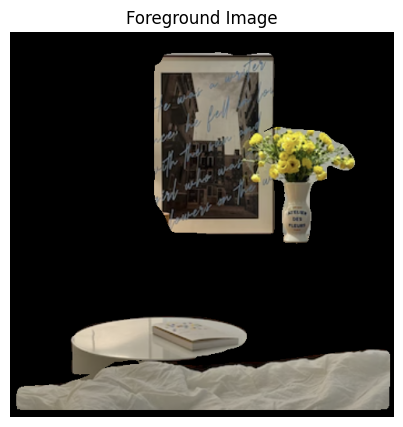

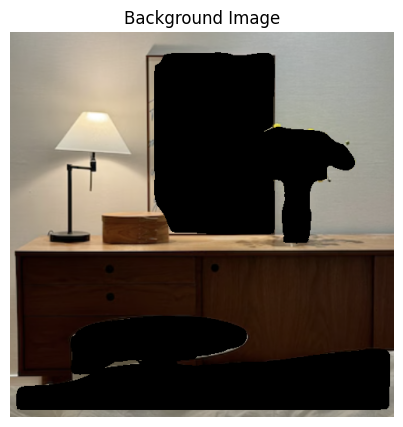

Foreground Color Palette with Weights:
Color 1: RGB(97, 91, 73), Weight: 0.13
Color 2: RGB(167, 160, 141), Weight: 0.36
Color 3: RGB(37, 31, 24), Weight: 0.18
Color 4: RGB(212, 200, 157), Weight: 0.07
Color 5: RGB(141, 135, 116), Weight: 0.26
     Color                 RGB Weight
0  Color 1     RGB(97, 91, 73)   0.13
1  Color 2  RGB(167, 160, 141)   0.36
2  Color 3     RGB(37, 31, 24)   0.18
3  Color 4  RGB(212, 200, 157)   0.07
4  Color 5  RGB(141, 135, 116)   0.26
Background Color Palette with Weights:
Color 1: RGB(170, 166, 154), Weight: 0.33
Color 2: RGB(38, 16, 6), Weight: 0.37
Color 3: RGB(212, 194, 168), Weight: 0.14
Color 4: RGB(83, 56, 35), Weight: 0.03
Color 5: RGB(151, 140, 121), Weight: 0.13
     Color                 RGB Weight
0  Color 1  RGB(170, 166, 154)   0.33
1  Color 2      RGB(38, 16, 6)   0.37
2  Color 3  RGB(212, 194, 168)   0.14
3  Color 4     RGB(83, 56, 35)   0.03
4  Color 5  RGB(151, 140, 121)   0.13


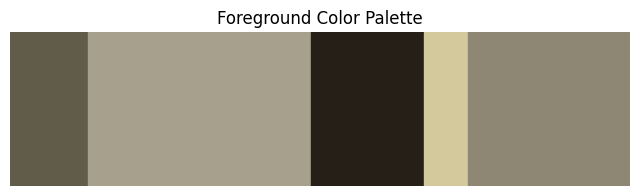

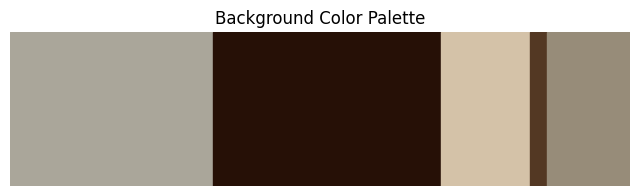

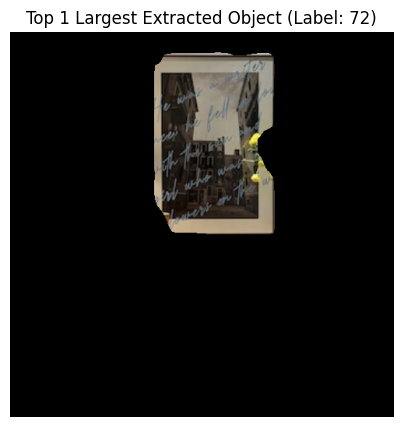

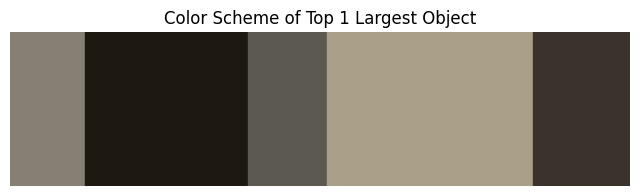

Top 1 Largest Object (Label: 72) occupies 13.94% of the image.


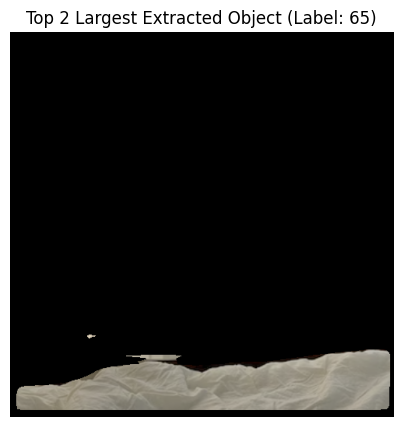

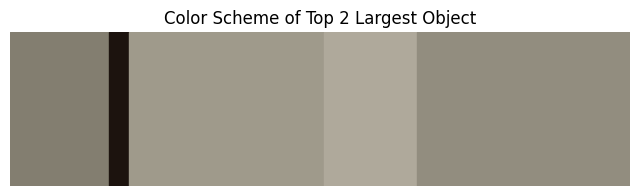

Top 2 Largest Object (Label: 65) occupies 11.65% of the image.


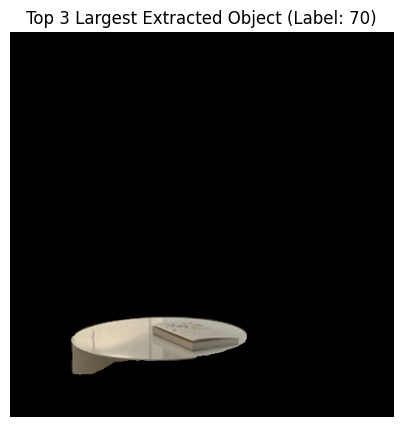

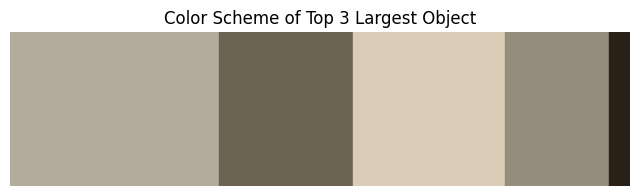

Top 3 Largest Object (Label: 70) occupies 4.73% of the image.


In [18]:
import cv2
import numpy as np
import os
import csv
from sklearn.cluster import KMeans
from PIL import Image
import torch
import torchvision.transforms as T
import torchvision
import torchvision.ops as ops  # NMS 적용을 위해 추가
import matplotlib.pyplot as plt
import pandas as pd
import random

import torch.backends.cudnn as cudnn

# 시드 고정 함수 수정
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        cudnn.deterministic = True
        cudnn.benchmark = False
        
# Mask R-CNN 모델 정의 및 로드
class ObjectSegmenter:
    def __init__(self, threshold=0.001, iou_threshold=0.3, brightness_threshold=200):
        set_seed()  # 시드 고정
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Pre-trained Mask R-CNN 모델 로드
        self.model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='MaskRCNN_ResNet50_FPN_Weights.COCO_V1')
        self.model.to(self.device)
        self.model.eval()
        self.threshold = threshold
        self.iou_threshold = iou_threshold
        self.brightness_threshold = brightness_threshold  # 밝기 기준 추가
        self.transform = T.Compose([T.ToTensor()])

    def segment_image(self, image_path):
        # 이미지 로드 및 전처리
        image = Image.open(image_path).convert("RGB")
        input_tensor = self.transform(image).unsqueeze(0).to(self.device)

        # 모델 추론
        with torch.no_grad():
            predictions = self.model(input_tensor)

        # 예측 결과에서 마스크와 클래스 추출
        boxes = predictions[0]['boxes']
        masks = predictions[0]['masks']
        labels = predictions[0]['labels']
        scores = predictions[0]['scores']

        # 특정 임계값 이상인 객체들만 선택
        keep = scores >= self.threshold
        boxes = boxes[keep]
        masks = masks[keep]
        labels = labels[keep]
        scores = scores[keep]

        # NMS (Non-Maximum Suppression)를 통해 중복된 객체 필터링
        keep_indices = ops.nms(boxes, scores, self.iou_threshold)
        boxes = boxes[keep_indices]
        masks = masks[keep_indices]
        labels = labels[keep_indices]
        scores = scores[keep_indices]

        # 최종 선택된 객체들의 마스크 및 레이블 저장
        selected_masks = []
        for i in range(len(scores)):
            mask = masks[i, 0].mul(255).byte().cpu().numpy()  # 마스크를 0-255로 스케일링
            selected_masks.append((mask, labels[i].item(), boxes[i]))

        return selected_masks, np.array(image)

    def extract_and_save_objects(self, image_np, masks, bright_objects_folder):
        # 배경 마스크 초기화 (모든 영역을 배경으로 시작)
        background_mask = np.ones(image_np.shape[:2], dtype=np.uint8) * 255

        # 각 객체의 마스크를 배경에 반영 (배경 마스크 업데이트)
        for mask, _, _ in masks:
            background_mask[mask > 128] = 0

        # 전경 이미지 생성 (배경을 제외한 나머지를 전경으로 설정)
        foreground_mask = background_mask == 0
        foreground_image = np.zeros_like(image_np)
        foreground_image[foreground_mask] = image_np[foreground_mask]

        # 밝은 영역 추가 탐지 (조명과 같은 작은 객체가 놓치는 경우 보완)
        bright_mask = cv2.cvtColor(foreground_image, cv2.COLOR_RGB2GRAY) > self.brightness_threshold
        bright_extracted_object = np.zeros_like(image_np)
        bright_extracted_object[bright_mask] = image_np[bright_mask]

        # 전경 이미지 시각화
        plt.figure(figsize=(5, 5))
        plt.imshow(foreground_image)
        plt.title("Foreground Image")
        plt.axis('off')
        plt.show()

        # 배경 이미지 생성
        background_image = np.zeros_like(image_np)
        background_mask_bool = background_mask == 255
        background_image[background_mask_bool] = image_np[background_mask_bool]

        # 배경 이미지 시각화
        plt.figure(figsize=(5, 5))
        plt.imshow(background_image)
        plt.title("Background Image")
        plt.axis('off')
        plt.show()

        # 전경 및 배경 색상 스키마 추출 및 가중치 계산
        foreground_colors, foreground_weights = self.calculate_color_palette_with_weights(foreground_mask, image_np)
        background_colors, background_weights = self.calculate_color_palette_with_weights(background_mask == 255, image_np)

        # 전경 및 배경 색상 스키마 출력
        self.print_palette_with_weights(foreground_colors, foreground_weights, "Foreground")
        self.print_palette_with_weights(background_colors, background_weights, "Background")
        self.plot_palette_with_weights(foreground_colors, foreground_weights, "Foreground Color Palette")
        self.plot_palette_with_weights(background_colors, background_weights, "Background Color Palette")

        # 상위 3개 객체 추출 및 비율 계산
        mask_areas = [(i, np.sum(mask > 128)) for i, (mask, _, _) in enumerate(masks)]
        top_3_masks = sorted(mask_areas, key=lambda x: x[1], reverse=True)[:3]

        for idx, (i, area) in enumerate(top_3_masks):
            mask, label, box = masks[i]
            # 객체 마스크에 따른 추출
            object_mask = mask > 128
            extracted_object = np.zeros_like(image_np)
            extracted_object[object_mask] = image_np[object_mask]

            # 추출된 객체 이미지 시각화
            plt.figure(figsize=(5, 5))
            plt.imshow(extracted_object)
            plt.title(f"Top {idx + 1} Largest Extracted Object (Label: {label})")
            plt.axis('off')
            plt.show()

            # 색상 스키마 추출
            object_colors = image_np[object_mask]
            if len(object_colors) > 0:
                kmeans_object = KMeans(n_clusters=min(len(object_colors), 5)).fit(object_colors.reshape(-1, 3))
                object_palette = kmeans_object.cluster_centers_
                object_weights = np.bincount(kmeans_object.labels_) / len(kmeans_object.labels_)
            else:
                object_palette = np.array([])
                object_weights = np.array([])

            # 색상 스키마 시각화 및 RGB 값 출력
            self.plot_palette_with_weights(object_palette, object_weights, f"Color Scheme of Top {idx + 1} Largest Object")

            # 객체가 이미지에서 차지하는 비율 계산 및 출력
            image_area = image_np.shape[0] * image_np.shape[1]
            object_ratio = area / image_area
            print(f"Top {idx + 1} Largest Object (Label: {label}) occupies {object_ratio:.2%} of the image.")

    def calculate_color_palette_with_weights(self, mask, image_np):
        # 마스크로부터 해당되는 색상 추출
        colors = image_np[mask]

        if len(colors) > 0:
            # KMeans를 이용해 클러스터링 및 가중치 계산
            kmeans = KMeans(n_clusters=min(len(colors), 5), random_state=42).fit(colors.reshape(-1, 3))
            unique_labels, counts = np.unique(kmeans.labels_, return_counts=True)
            weights = counts / counts.sum()  # 각 클러스터의 픽셀 수를 가중치로 사용
            return kmeans.cluster_centers_, weights
        else:
            return np.array([]), np.array([])

    def print_palette_with_weights(self, colors, weights, label):
        if len(colors) == 0:
            print(f"No colors to display for {label}")
            return

        print(f"{label} Color Palette with Weights:")
        data = []
        for i, (color, weight) in enumerate(zip(colors, weights)):
            print(f"Color {i + 1}: RGB({color[0]:.0f}, {color[1]:.0f}, {color[2]:.0f}), Weight: {weight:.2f}")
            data.append([f"Color {i + 1}", f"RGB({color[0]:.0f}, {color[1]:.0f}, {color[2]:.0f})", f"{weight:.2f}"])
        df = pd.DataFrame(data, columns=["Color", "RGB", "Weight"])
        print(df)

    def plot_palette_with_weights(self, colors, weights, title):
        if len(colors) == 0:
            print(f"No colors to display for {title}")
            return

        total_weight = np.sum(weights)
        fig, ax = plt.subplots(1, 1, figsize=(8, 2))
        current_x = 0

        for i, (color, weight) in enumerate(zip(colors, weights)):
            width = weight / total_weight  # 가중치에 비례한 너비
            ax.add_patch(plt.Rectangle((current_x, 0), width, 1, color=color / 255.0))
            current_x += width

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')
        ax.set_title(title)
        plt.show()


# 이미지 파일 경로 정의
image_path = "./rr.png"

# ObjectSegmenter 인스턴스 생성 및 객체 분할 수행
segmenter = ObjectSegmenter(threshold=0.001, iou_threshold=0.3, brightness_threshold=230)
masks, image_np = segmenter.segment_image(image_path)

# 전경 및 배경의 색상 스키마와 가중치 출력 및 밝은 객체 저장
segmenter.extract_and_save_objects(image_np, masks, bright_objects_folder)
